In [1]:
#files
import sys
#from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
#from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds
from models import SimpleRNN, LSTM, MLP
#from lstm_models import LSTM
import utils_2 as ut2
from traindata import trainData
import errores as er



#data and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score

sns.set_style("darkgrid")


import numpy as np
import random
import os, errno
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data_utils


np.random.seed(seed=77)
torch.manual_seed(77)

c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import copy
fpath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/low/"
fname = "file1_080124.mat"
#cutoff = [8/1000, 11/1000]

data = trainData(fpath, fname, 'Amplitude')
train, val, test = data.split_data('Amplitude')


import copy

train = utils.subsample(train, 2)
test = utils.subsample(test, 2)

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))

test = copy.deepcopy(test_scaled)

x_train, y_train = ut2.create_sequences(train_scaled[:], 1000, 1)
x_test, y_test = ut2.create_sequences(test_scaled, 1000, 1)

x_train = torch.from_numpy(x_train.astype(np.float32)).squeeze()



0         0.001705
1         0.001436
2         0.001494
3         0.001446
4         0.001489
            ...   
599995    0.000679
599996    0.000686
599997    0.000843
599998    0.000868
599999    0.001361
Name: Amplitude, Length: 600000, dtype: float64
0         0.001705
1         0.001436
2         0.001494
3         0.001446
4         0.001489
            ...   
599995    0.000679
599996    0.000686
599997    0.000843
599998    0.000868
599999    0.001361
Name: Amplitude, Length: 600000, dtype: float64
0         0.001705
1         0.001436
2         0.001494
3         0.001446
4         0.001489
            ...   
599995    0.000679
599996    0.000686
599997    0.000843
599998    0.000868
599999    0.001361
Name: Amplitude, Length: 600000, dtype: float64
0         0.001705
1         0.001436
2         0.001494
3         0.001446
4         0.001489
            ...   
599995    0.000679
599996    0.000686
599997    0.000843
599998    0.000868
599999    0.001361
Name: Amplitude, Len

## **modelo**

In [3]:
in_size = x_train.shape[-1]
out_size = 1
hid_size = x_train.shape[-1]//2
num_layers = 2

model = MLP(in_size, hid_size, out_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [4]:
utils.resume(model, optimizer, 'earlystop_180.pth')

In [5]:
def rollingWindowPrediction(model, x_test, steps = 50):
    output = []
    N = x_test.size()[-1]
    print(N)

    with torch.no_grad():
        model.eval()
        for elem in tqdm(x_test):
            elem = elem.view(N).unsqueeze(0)
            #print(elem.shape)
            test_aux = []
            count = 0
            while count < steps:
                    pred = model(elem)
                    #print(pred.shape)
                    test_aux.append(pred[0,0].item())
                    elem = torch.cat((elem.squeeze(0)[1:], pred[0])).unsqueeze(0)
                    count += 1

            output.append(test_aux)
    return output

## **50 steps**

In [19]:
steps = 50
x_test , y_test = ut2.create_sequences(test, 1000, steps)
x_test = torch.from_numpy(x_test.astype(np.float32)).squeeze()
y_test = torch.from_numpy(y_test.astype(np.float32)).squeeze()


In [15]:
test50 = ut2.rollingWindowPrediction(model, x_test, steps)
np.savetxt("test50_MLP.csv", test50, delimiter=",")

100%|██████████| 3951/3951 [01:26<00:00, 45.90it/s]


In [16]:
test50 = np.loadtxt("test50_MLP.csv", delimiter=",")

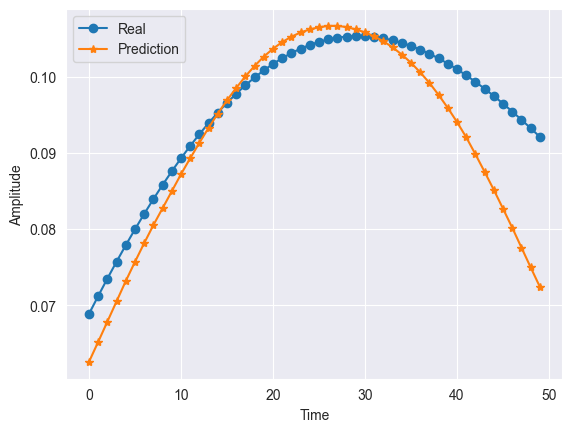

In [17]:
i = 0
plt.plot(y_test[i], 'o-',label='Real')
plt.plot(test50[i], '*-',label='Prediction')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [20]:
mse, mape, r2, rmse = er.calculate_errors(test50, y_test)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R2 Score: {r2}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 0.002104048301631961
Mean Absolute Percentage Error: 0.3273101101809209
R2 Score: 0.617397609740456
Root Mean Squared Error: 0.04248271868862549


## **100 steps**

In [9]:
steps = 100
x_test , y_test = ut2.create_sequences(test, 1000, steps)
x_test = torch.from_numpy(x_test.astype(np.float32)).squeeze()
y_test = torch.from_numpy(y_test.astype(np.float32)).squeeze()

In [10]:
test100 = ut2.rollingWindowPrediction(model, x_test, steps)
np.savetxt("test100_MLP.csv", test100, delimiter=",")

100%|██████████| 43901/43901 [27:56<00:00, 26.18it/s]


In [11]:
mse, mape, r2, rmse = er.calculate_errors(test100, y_test)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R2 Score: {r2}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 0.003941422406461579
Mean Absolute Percentage Error: 97.3071375434775
R2 Score: -11087.426167279122
Root Mean Squared Error: 0.06249912415855117


## **500 steps**

In [12]:
steps = 500
x_test , y_test = ut2.create_sequences(test, 1000, steps)
x_test = torch.from_numpy(x_test.astype(np.float32)).squeeze()
y_test = torch.from_numpy(y_test.astype(np.float32)).squeeze()

In [13]:
test500 = ut2.rollingWindowPrediction(model, x_test, steps)
np.savetxt("test500_MLP.csv", test500, delimiter=",")

100%|██████████| 43501/43501 [2:15:47<00:00,  5.34it/s]  


In [14]:
mse, mape, r2, rmse = er.calculate_errors(test500, y_test)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R2 Score: {r2}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 0.004955952832904671
Mean Absolute Percentage Error: 108.83256898042552
R2 Score: -13876.818195752341
Root Mean Squared Error: 0.06980662207323801


## **1000 steps**

In [15]:
steps = 1000
x_test , y_test = ut2.create_sequences(test, 1000, steps)
x_test = torch.from_numpy(x_test.astype(np.float32)).squeeze()
y_test = torch.from_numpy(y_test.astype(np.float32)).squeeze()

In [16]:
test1000 = ut2.rollingWindowPrediction(model, x_test, steps)
np.savetxt("test1000_MLP.csv", test1000, delimiter=",")

100%|██████████| 43001/43001 [5:26:23<00:00,  2.20it/s]     


In [17]:
mse, mape, r2, rmse = er.calculate_errors(test1000, y_test)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R2 Score: {r2}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 0.003770648403513756
Mean Absolute Percentage Error: 93.98867334537418
R2 Score: -10518.919541323963
Root Mean Squared Error: 0.06026523956957966
